In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction:
- In this notebook, I have **pre-processed ,analyzed, detected and treated several anomalies/outliers** using multiple techniques on the battery charge / discharge dataset obtained from NASA.
- I have used 5 most widely used anomalies/outliers detection techniques such as:
    - IQR based
    - DBSCAN (density based)
    - Isolation Forest
    - Local Outlier Factor (LOF)
    - Elliptical Envelope

# Problem Statement:
- NASA is experimenting on making hydrogen Fuel Cell Electric Vehicle (FCEV) for space. An FCEV is powered by a hydrogen fuel cell, which generates electric power using on-board hydrogen. On a full tank, this FCEV can go up to a claimed 600 kilometers.
- They have reached out to the **Data Science team in NASA** for helping them in understanding some parameters related to Hydrogen Fuel cell sensors. As a data scientist working in the R&D team of NASA, **you need to analyze the aging process, charge, and discharge cycle of the cell and isolate some anomalies/ instances you see in the data.**

## Data Dictionary:
- Voltage_measured: Fuel Cell terminal voltage (Volts)
- Current_measured: Fuel Cell output current (Amps)
- Temperature_measured: Fuel Cell temperature (degree C)
- Current_load: Current measured at load (Amps)
- Voltage_load: Voltage measured at load (Volts)
- Time: Time vector for the cycle (seconds)
- Capacity: Fuel Cell capacity (Ahr) for discharge till 2.7V
- Datetime: the date and time of the start of the cycle
- Ambient_temperature: Temperature in which the fuel cell is stored (degree C)
- Cycle: Charge cycle of the fuel cell

## Data Description:
- A set of four Fuel cells (# 5, 6, 7 and 18) were run through 2 different operational profiles (charge& discharge) at room temperature. Charging was carried out in a constant current (CC) mode at 1.5A until the Fuel cell voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. Discharge was carried out at a constant current (CC) level of 2A until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for Fuel cell 5 6 7 and 18 respectively.
- Repeated charge and discharge cycles result in accelerated aging of the Fuel cell. The experiments were stopped when the Fuel cell reached end-of-life (EOL) criteria, which was a 30% fade in rated capacity (from 2Ahr to 1.4Ahr).

- This data can be further used for the prediction of both remaining charge (for a given discharge cycle) and remaining useful life (RUL).

 - Files:

    - B0005.mat Data for Fuel cell #5

    - B0006.mat Data for Fuel cell #6

    - B0007.mat Data for Fuel cell #7

    - B0018.mat Data for Fuel cell #18


### Importing libraries:


In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Converting the matlab files to csv:

def load_data(nm,battery): # Example of input load_data('B0006.mat','B0006')
    mat = loadmat(nm)
    #print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
    counter = 0
    dataset = []
    capacity_data = []
  
    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge' :
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(int(row['time'][0][0]),
                                   int(row['time'][0][1]),
                                   int(row['time'][0][2]),
                                   int(row['time'][0][3]),
                                   int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                voltage_measured, current_measured,
                                temperature_measured, current_load,
                                voltage_load, time])
                capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
                counter = counter + 1
#     print(dataset[0])
    return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

In [5]:
n = 'B0005'
df = pd.read_csv('data_frames/' + 'NASA_cycle_dataset_' + n +'.csv',
                 parse_dates = ["datetime"]).drop(["Unnamed: 0"], axis = 1)
df.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,NaN
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,NaN
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,NaN
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,NaN
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,NaN


B0005_dataset, B0005_capacity = load_data(('battery_data/' + 'datasets/' + 'B0005.mat'),'B0005')
B0005_dataset['flag'] = 1

# temp = loadmat(os.path("battery_data"+"B0005.mat"))

B0006_dataset, B0006_capacity = load_data(('battery_data/' + 'datasets/' + 'B0006.mat'),'B0006')
B0006_dataset['flag'] = 2

B0007_dataset, B0007_capacity = load_data(('battery_data/' + 'datasets/' + 'B0007.mat'),'B0007')
B0007_dataset['flag'] = 3

B0018_dataset, B0018_capacity = load_data(('battery_data/' + 'datasets/' + 'B0018.mat'),'B0018')
B0018_dataset['flag'] = 4

fuel_cells_df = pd.concat([B0005_dataset], ignore_index = True)   #

In [6]:
fuel_cells_df = df.copy()
fuel_cells_df

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,NaN
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,NaN
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,NaN
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,NaN
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,NaN
...,...,...,...,...,...,...,...,...,...,...
591453,170,24,2008-05-28 11:09:42,0.236356,-0.003484,23.372048,0.000,0.003,0.000,NaN
591454,170,24,2008-05-28 11:09:42,0.003365,-0.001496,23.369434,0.000,0.003,2.547,NaN
591455,170,24,2008-05-28 11:09:42,4.985137,0.000506,23.386535,0.000,5.002,5.500,NaN
591456,170,24,2008-05-28 11:09:42,4.984720,0.000442,23.386983,-0.002,5.002,8.312,NaN


### Identification of variables and data types:

In [7]:
fuel_cells_df.shape

(591458, 10)

In [8]:
fuel_cells_df.columns

Index(['cycle', 'ambient_temperature', 'datetime', 'voltage_measured',
       'current_measured', 'temperature_measured', 'current', 'voltage',
       'time', 'capacity'],
      dtype='object')

In [9]:
fuel_cells_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591458 entries, 0 to 591457
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   cycle                 591458 non-null  int64         
 1   ambient_temperature   591458 non-null  int64         
 2   datetime              591458 non-null  datetime64[ns]
 3   voltage_measured      591458 non-null  float64       
 4   current_measured      591458 non-null  float64       
 5   temperature_measured  591458 non-null  float64       
 6   current               591458 non-null  float64       
 7   voltage               591458 non-null  float64       
 8   time                  591458 non-null  float64       
 9   capacity              50285 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 45.1 MB


### Unique values:

In [10]:
for i in fuel_cells_df.columns:
    print(i, ":" , fuel_cells_df[i].nunique())
       

cycle : 170
ambient_temperature : 1
datetime : 338
voltage_measured : 591458
current_measured : 591458
temperature_measured : 591458
current : 1142
voltage : 1514
time : 442401
capacity : 168


In [11]:
fuel_cells_df.drop('ambient_temperature', axis = 1, inplace = True)

In [12]:
fuel_cells_df

,cycle,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,NaN
1,1,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,NaN
2,1,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,NaN
3,1,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,NaN
4,1,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,NaN
...,...,...,...,...,...,...,...,...,...
591453,170,2008-05-28 11:09:42,0.236356,-0.003484,23.372048,0.000,0.003,0.000,NaN
591454,170,2008-05-28 11:09:42,0.003365,-0.001496,23.369434,0.000,0.003,2.547,NaN
591455,170,2008-05-28 11:09:42,4.985137,0.000506,23.386535,0.000,5.002,5.500,NaN
591456,170,2008-05-28 11:09:42,4.984720,0.000442,23.386983,-0.002,5.002,8.312,NaN


In [13]:
fuel_cells_df.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
cycle,591458.0,95.885468,43.030452,1.000000,61.000000,96.000000,133.000000,170.000000
voltage_measured,591458.0,4.103945,0.213469,0.003365,4.089426,4.205140,4.205908,8.393141
current_measured,591458.0,0.369404,0.907558,-4.479660,0.040636,0.171961,1.259778,1.531301
temperature_measured,591458.0,26.369701,2.772424,23.214802,24.488485,25.479630,27.348768,41.450232
current,591458.0,0.634476,0.737029,-4.468000,0.057000,0.261000,1.498000,1.998400
voltage,591458.0,4.024930,1.208825,0.000000,4.240000,4.305000,4.656000,5.002000
time,591458.0,4763.856934,3147.859026,0.000000,1928.175750,4467.515500,7503.824000,10807.328000
capacity,50285.0,1.560345,0.182380,1.287453,1.386229,1.538237,1.746871,1.856487


In [14]:
# Missing values:

def missingValue(df):
    #Identifying Missing data.
    total_null = df.isnull().sum().sort_values(ascending = False)
    percent = ((df.isnull().sum()/len(df))*100).sort_values(ascending = False)
    print(f"Total records in our data =  {df.shape[0]} where missing values are as follows:")

    missing_data = pd.concat([total_null,percent.round(2)],axis=1,keys=['Total Missing','In Percent'])
    return missing_data

In [15]:
missing_df = missingValue(fuel_cells_df)
missing_df[missing_df['Total Missing'] > 0]

Total records in our data =  591458 where missing values are as follows:


,Total Missing,In Percent
capacity,541173,91.5


In [16]:
capacity_counts = pd.DataFrame(fuel_cells_df.groupby('cycle')['capacity'].nunique())
zero_capacity_rows = capacity_counts[capacity_counts['capacity'] != 1]
# capacity_counts
zero_capacity_rows

,capacity
cycle,
169,0
170,0


In [17]:
fuel_cells_df = fuel_cells_df[fuel_cells_df['cycle'] <  169]
caps = pd.DataFrame(fuel_cells_df.groupby('cycle')['capacity'].max())
temp = fuel_cells_df.merge(caps, on='cycle', how='left').ffill()
temp = temp.drop(["capacity_x"], axis = 1).rename(columns = {"capacity_y" : "capacity"})
fuel_cells_df = temp

In [18]:
missing_df = missingValue(fuel_cells_df)
missing_df[missing_df['Total Missing'] > 0]

Total records in our data =  587849 where missing values are as follows:


,Total Missing,In Percent


# Univariate Analysis:

In [19]:
def numerical_feat(df,colname,nrows=2,mcols=2,width=15,height=70):
    fig , ax = plt.subplots(nrows,mcols,figsize=(width,height))
    fig.set_facecolor("lightgrey")
    rows = 0
    for var in colname:        
        ax[rows][0].set_title("Boxplot for Outlier Detection ", fontweight="bold")
        plt.ylabel(var, fontsize=12)
        sns.boxplot(y = df[var],color='crimson',ax=ax[rows][0])
        
        sns.histplot(df[var],color='purple',ax=ax[rows][1],kde=True)
        ax[rows][1].axvline(df[var].mean(), color='r', linestyle='--', label="Mean")
        ax[rows][1].axvline(df[var].median(), color='m', linestyle='-', label="Median")
        ax[rows][1].axvline(df[var].mode()[0], color='royalblue', linestyle='-', label="Mode")
        ax[rows][1].set_title("Outlier Detection ", fontweight="bold")
        ax[rows][1].legend({'Mean':df[var].mean(),'Median':df[var].median(),'Mode':df[var].mode()})
        rows += 1
    plt.show()

In [20]:
fuel_cells_df.columns

Index(['cycle', 'datetime', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current', 'voltage', 'time', 'capacity'],
      dtype='object')

In [31]:
numerical_cols = ['capacity', 'voltage_measured']

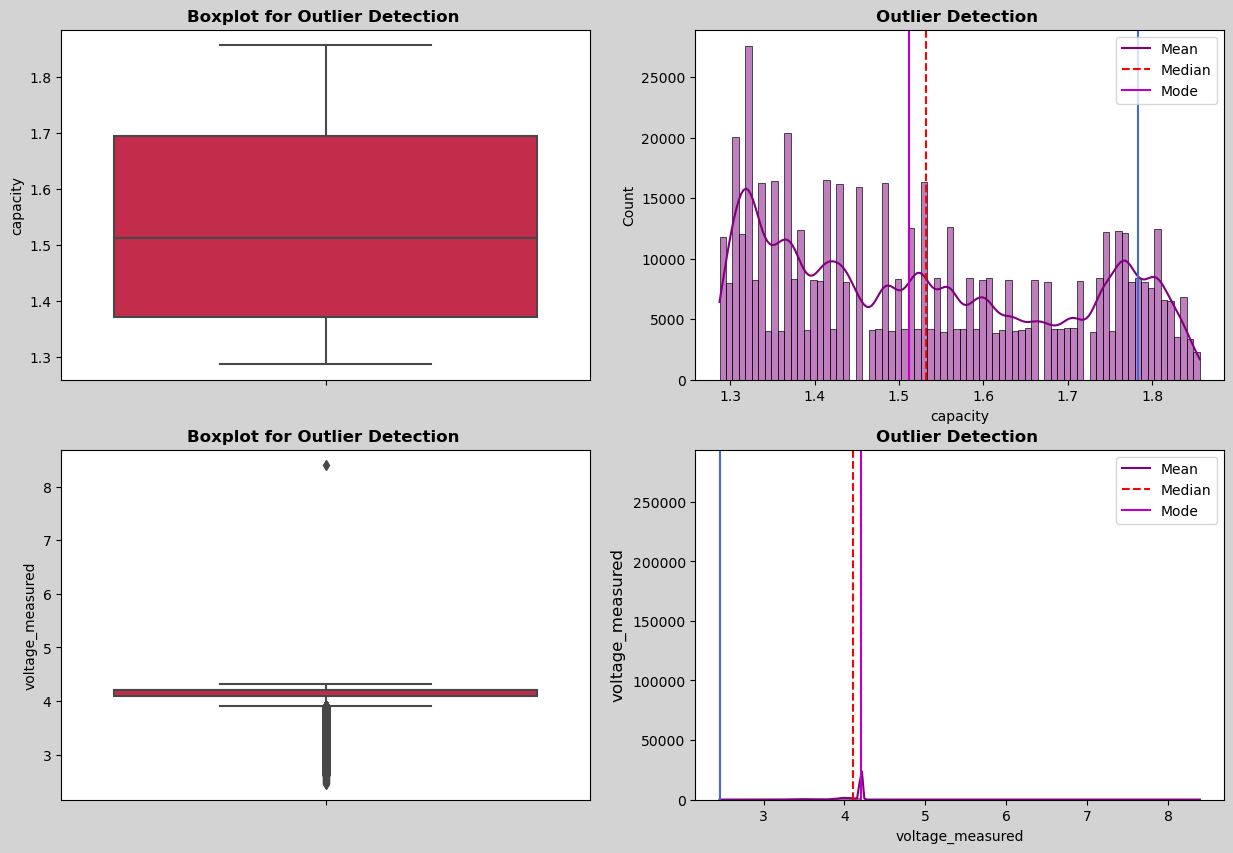

In [32]:
numerical_feat(fuel_cells_df,numerical_cols,len(numerical_cols),2,15,10)

We can see a single large outlier in voltage measured with appears to be a large error as it is way above the cell capability.

In [33]:
value = fuel_cells_df['voltage_measured'].max()
fuel_cells_df = fuel_cells_df[fuel_cells_df['voltage_measured'] != value]

In [34]:
numerical_cols = ['capacity', 'voltage_measured']

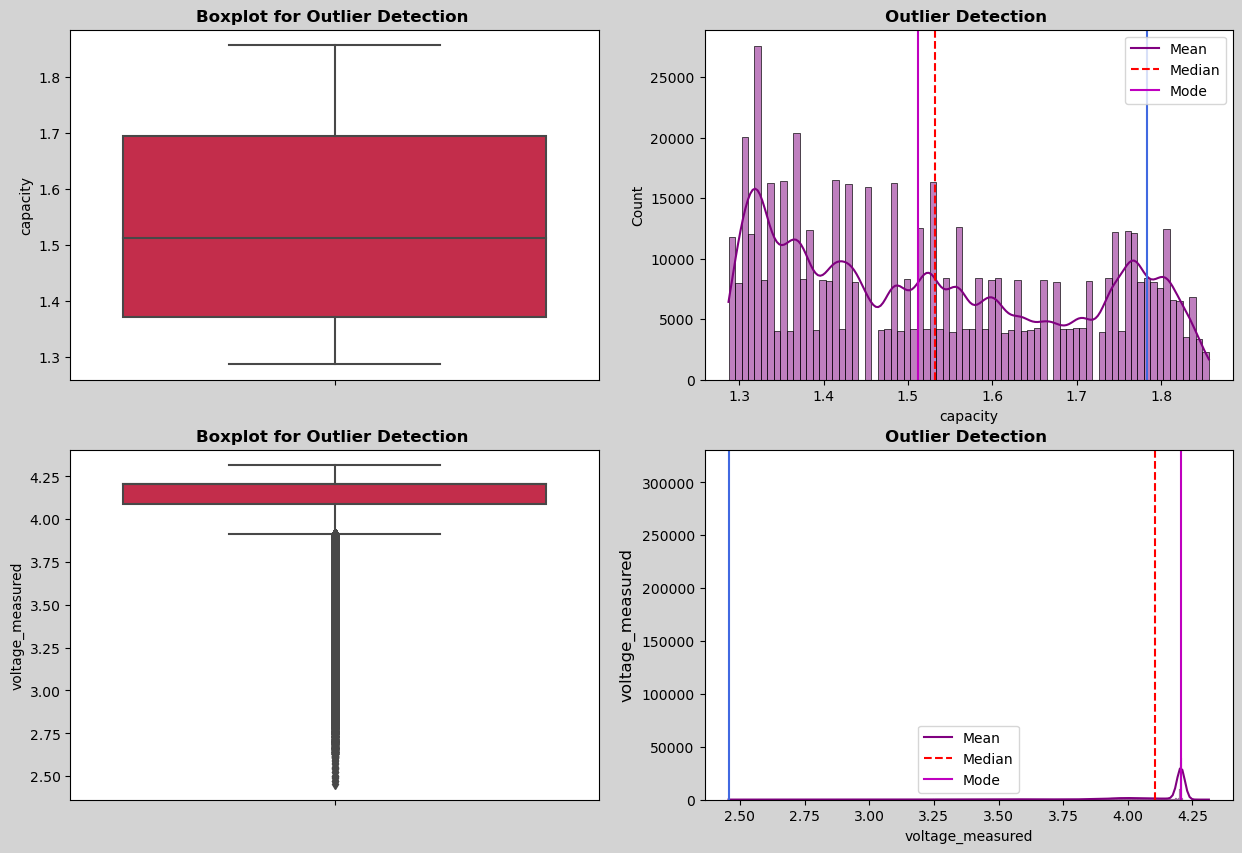

In [35]:
numerical_feat(fuel_cells_df,numerical_cols,len(numerical_cols),2,15,10)

- As we can see, the voltage_measured load has normal distribution with many outliers to the lower end as it discharges. It is also interesting to see some values beolow the rated lowest discharge of these cells at 2.7 vo
- Whereas, capacity is multimodal distributed having almost zero outliers.

categorical_cols = ['flag']

plt.figure(figsize = (7,8))
count = (fuel_cells_df['flag'].value_counts(normalize=True)*100)
count.plot.pie(colors = sns.color_palette("flare"),autopct='%0.0f%%',
                       textprops={'fontsize': 14},shadow = True)
plt.show()

- Battery 4 has least no. of datapoints, whereas the other three have equal no. of dp.

# Bivariate Analysis:

In [42]:
fuel_cells_df.columns

Index(['cycle', 'datetime', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current', 'voltage', 'time', 'capacity'],
      dtype='object')

### 1. Capacity w.r.t Cycle

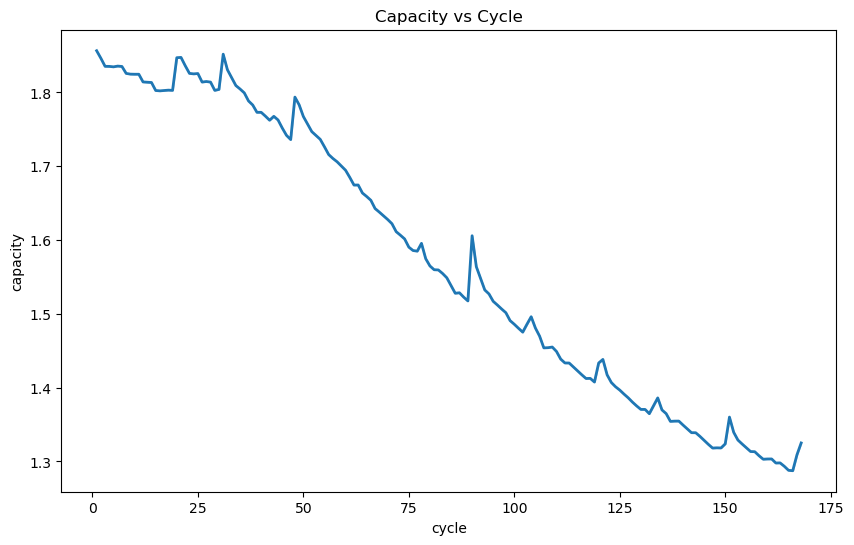

In [71]:
plt.figure(figsize=(10, 6))
sns.lineplot(x = 'cycle', y = 'capacity', data = fuel_cells_df, linewidth = 2)
plt.title('Capacity vs Cycle')
plt.show()


- As the cycle increases, the batterry capacities is showing a decreasing trend.
- Capacity of batteries decrease as no. of cycles of battery usage increases

### 2. Datetime w.r.t time 

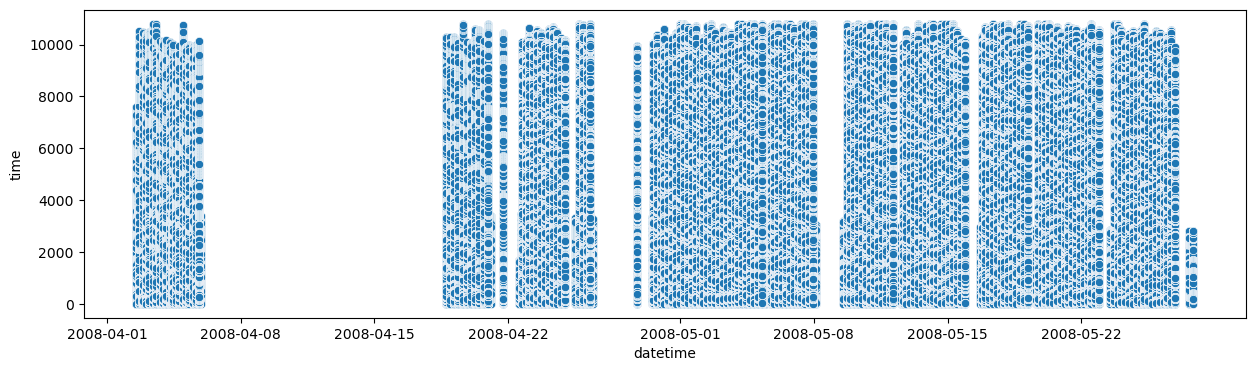

In [45]:
plt.figure(figsize=(15, 4))
sns.scatterplot(x = 'datetime', y = 'time', data = fuel_cells_df)
plt.show()

- There hasn't been a continuos testing of charging of batteries throught the cycle. 
- There is an intereseting break between the first and later batches of testing

### 3.Datetime w.r.t capacity

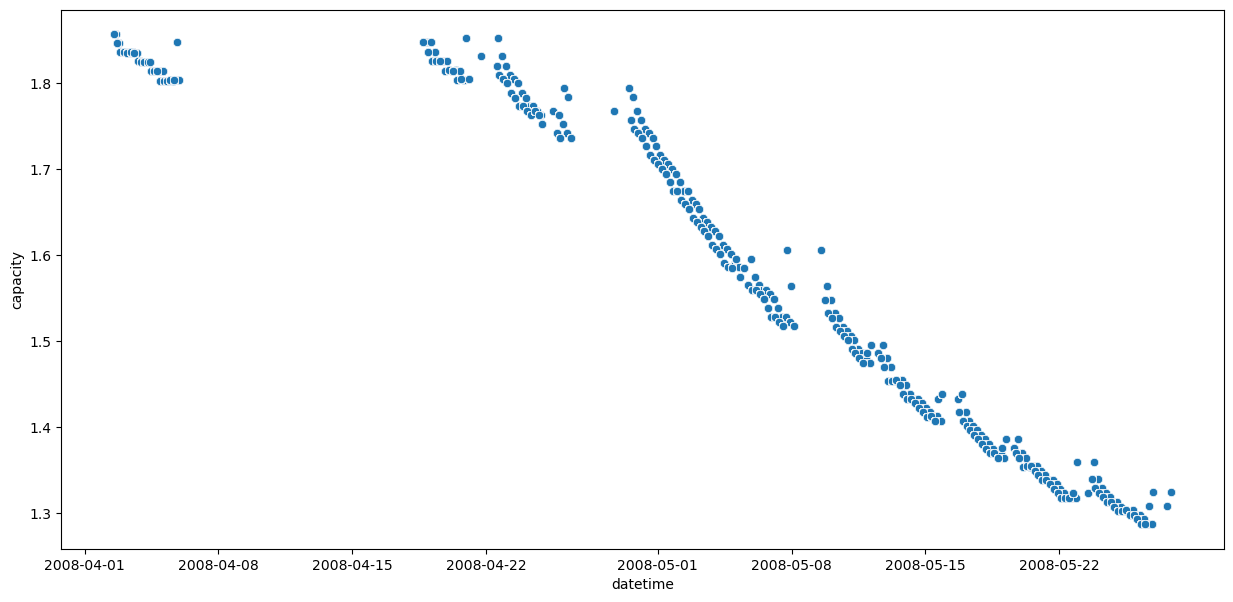

In [46]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x = 'datetime', y = 'capacity', data = fuel_cells_df)
plt.show()

- Capacity decreases over a period of time.

### 4. Capacity w.r.t time

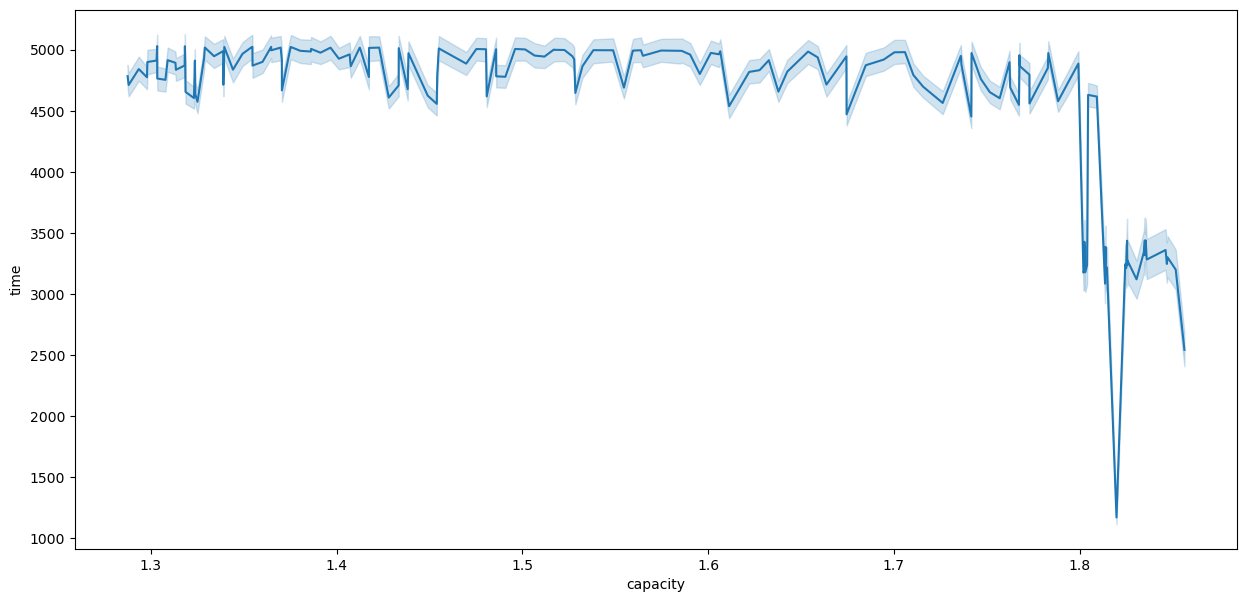

In [47]:
plt.figure(figsize=(15, 7))
sns.lineplot(x = 'capacity', y = 'time', data = fuel_cells_df)
plt.show()

### 5. Temperature w.r.t time

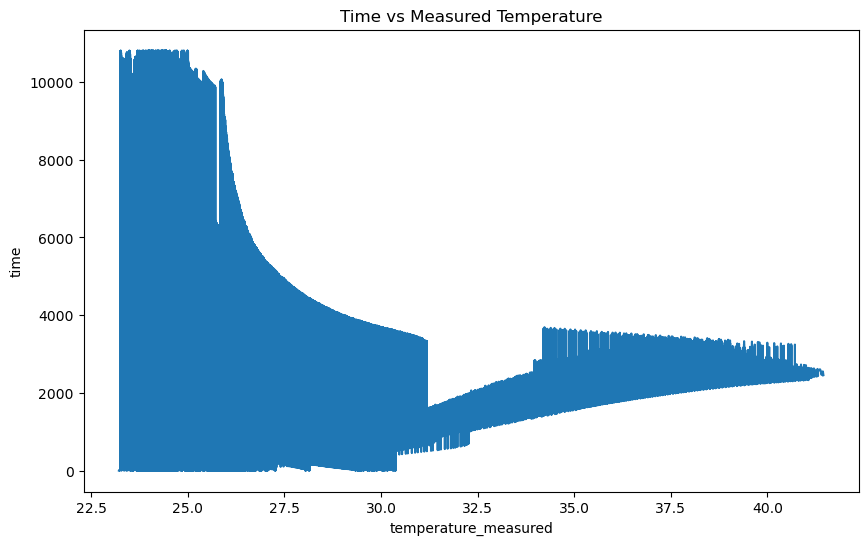

In [72]:
plt.figure(figsize=(10, 6))
sns.lineplot(x = 'temperature_measured', y = 'time', data = fuel_cells_df)
plt.title('Time vs Measured Temperature')
plt.show()

-  We can see the longer cycles can occure at lower temperatures, and cycle length decreases as temperature increases

### 6. Voltage measured w.r.t time

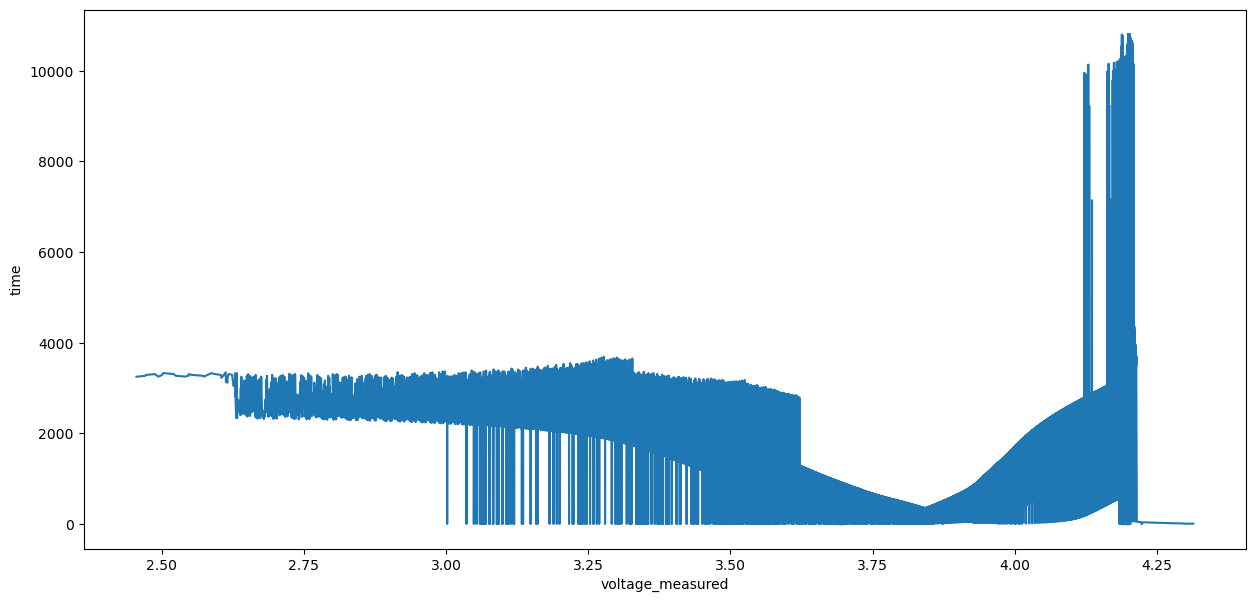

In [49]:
plt.figure(figsize=(15, 7))
sns.lineplot(x = 'voltage_measured', y = 'time', data = fuel_cells_df)
plt.show()

- As clearly visible, Battery (B0006) with flag 2 has max no. of outliers

### 7. Current measured w.r.t time

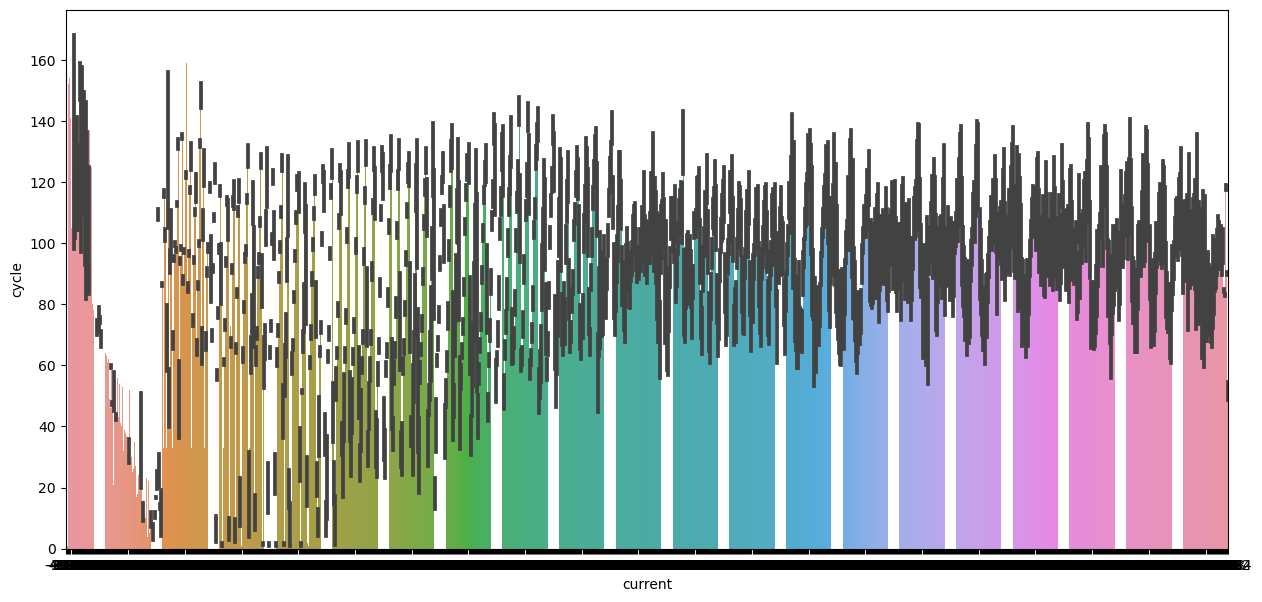

In [53]:
plt.figure(figsize=(15, 7))
sns.barplot(x = 'current', y = 'cycle', data = fuel_cells_df)
plt.show()

- As clearly visible, Batter (B0006) with flag 2 has max no. of outliers

### 8. Correlation between various features

<!-- ![image.png](attachment:image.png) -->

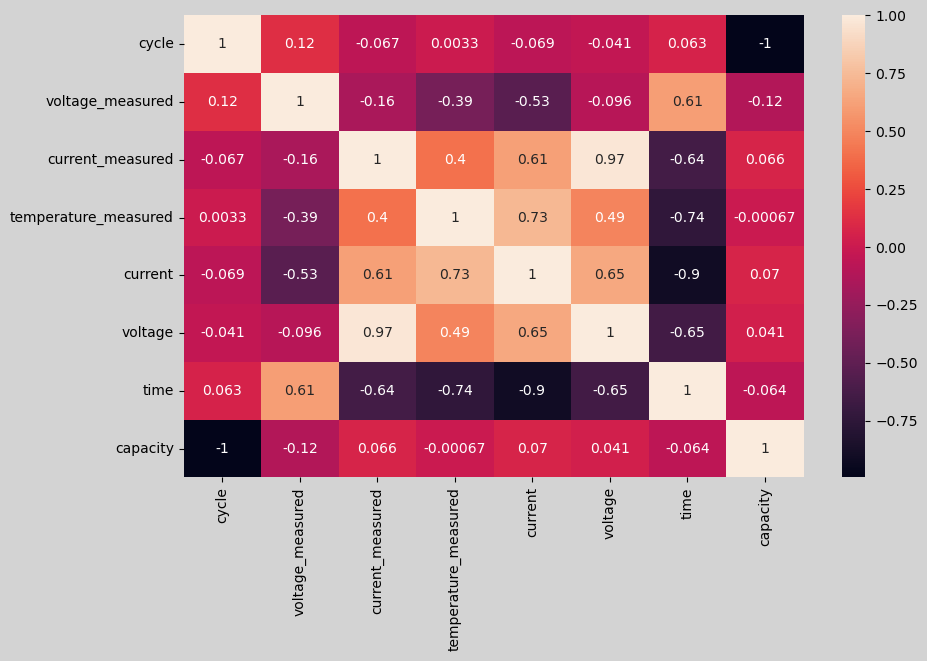

In [64]:
fig, ax = plt.subplots(figsize = (10,6))
fig.set_facecolor("lightgrey")
sns.heatmap(fuel_cells_df.corr(method = 'spearman'), annot = True)
plt.show()

- cycle & capacity -> negatively correlated.
- volatage load and voltage_measured -> negatively correlated.
- voltage_measured and time -> positively correlated.
- temperature and time -> positively correlated.

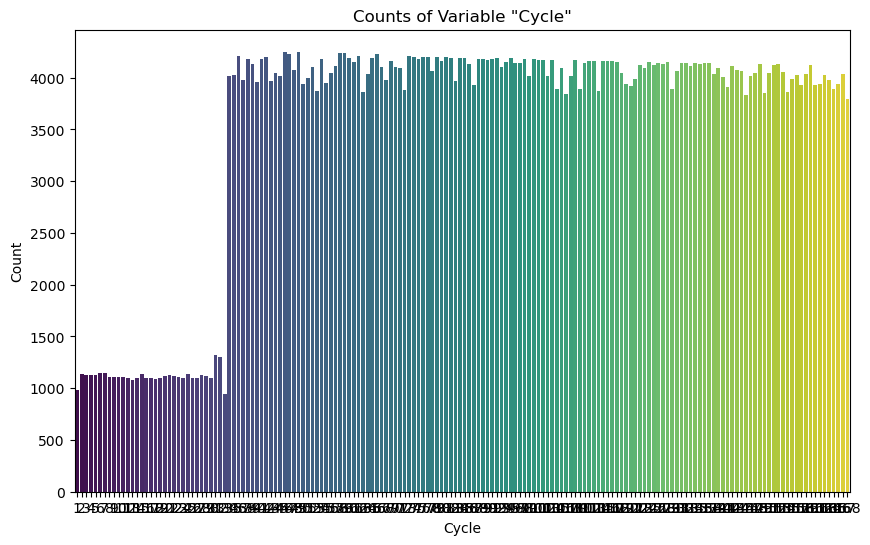

In [57]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.countplot(x='cycle', data=fuel_cells_df, palette='viridis')
# Adding labels and title
plt.xlabel('Cycle')
plt.ylabel('Count')
plt.title('Counts of Variable "Cycle"')

# Show the plot
plt.show()

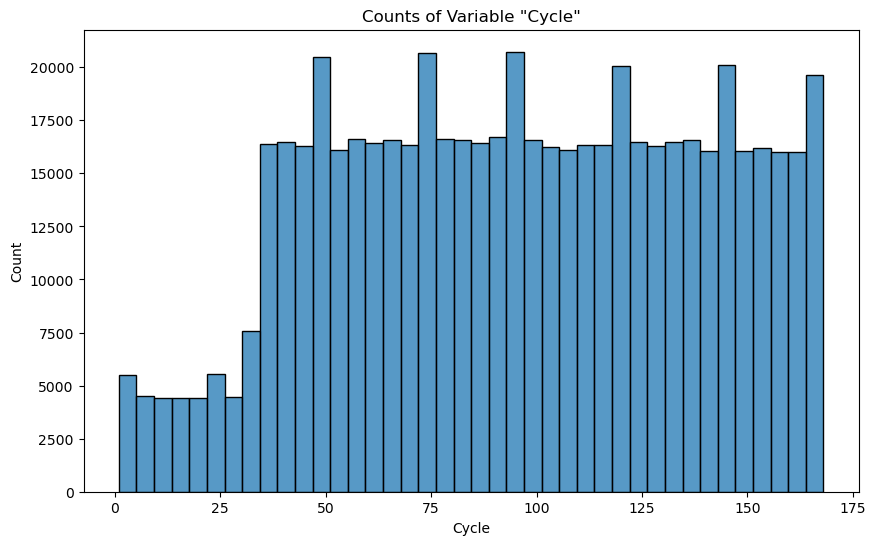

In [62]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.histplot(bins = 40, x='cycle', data=fuel_cells_df, palette='viridis')
# Adding labels and title
plt.xlabel('Cycle')
plt.ylabel('Count')
plt.title('Counts of Variable "Cycle"')

# Show the plot
plt.show()

In [19]:
data_array = [{"model" : "DNN",       "time" : 5, "step_time" : 1},
              {"model" : "CNN",       "time" : 7, "step_time" : 2},
              {"model" : "RNN",       "time" : 9, "step_time" : 2},
              {"model" : "LSTM",      "time" : 16, "step_time" : 3},
              {"model" : "GRU",       "time" : 10, "step_time" : 3},
              {"model" : "BiDirRNN",  "time" : 12, "step_time" : 3},
              {"model" : "BiDirLSTM", "time" : 21, "step_time" : 4},
              {"model" : "BiDirGRU",  "time" : 19, "step_time" : 4},
              {"model" : "RBFN",      "time" : 5, "step_time" : 1},
              {"model" : "DBN",       "time" : 5, "step_time" : 1}]
# predict 3675 rows

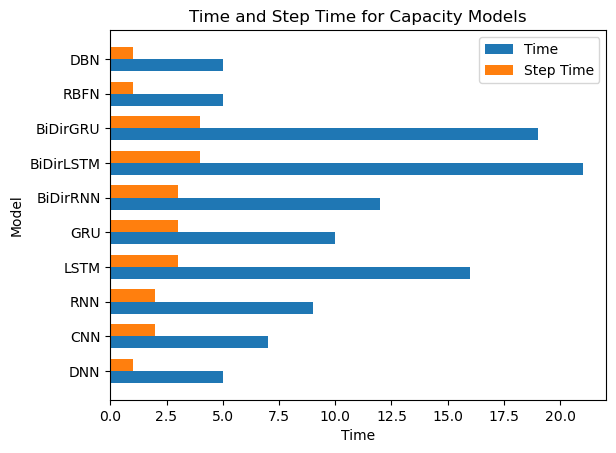

In [20]:
# Extracting data for plotting
models = [entry["model"] for entry in data_array]
time_values = [entry["time"] for entry in data_array]
step_time_values = [entry["step_time"] for entry in data_array]

# Plotting horizontal grouped bars
bar_width = 0.35
index = np.arange(len(models))

fig, ax = plt.subplots()

# Grouped bar plot
bar1 = ax.barh(index, time_values, bar_width, label='Time')
bar2 = ax.barh(index + bar_width, step_time_values, bar_width, label='Step Time')

# Adding titles and labels
ax.set_title('Time and Step Time for Capacity Models')
ax.set_ylabel('Model')
ax.set_xlabel('Time')

# Adding legend
ax.legend()

# Adjusting y-axis ticks and labels
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(models)

# Display the plot
plt.show()


In [1]:
data_array = [{"model" : "DNN",      "time" : 5, "step_time" : 1},
              {"model" : "CNN",       "time" : 9, "step_time" : 2},
              {"model" : "RNN",       "time" : 6, "step_time" : 2},
              {"model" : "LSTM",      "time" : 12, "step_time" : 3},
              {"model" : "GRU",       "time" : 13, "step_time" : 3},
              {"model" : "BiDirRNN",  "time" : 10, "step_time" : 2},
              {"model" : "BiDirLSTM", "time" : 15, "step_time" : 4},
              {"model" : "BiDirGRU",  "time" : 26, "step_time" : 7},
              {"model" : "RBFN",      "time" : 7, "step_time" : 2},
              {"model" : "DBN",       "time" : 9, "step_time" : 8}]
# predict 3675 rows

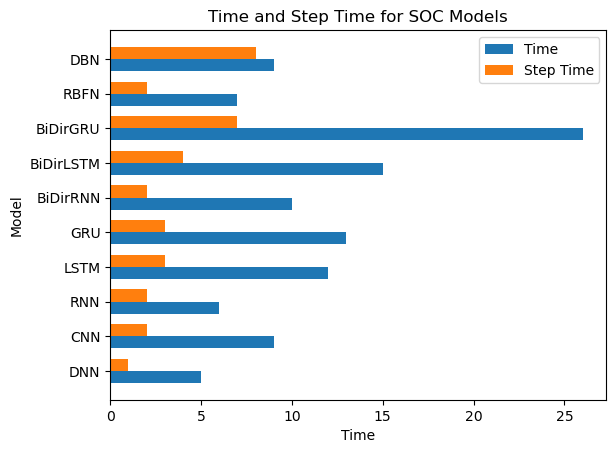

In [5]:
# Extracting data for plotting
models = [entry["model"] for entry in data_array]
time_values = [entry["time"] for entry in data_array]
step_time_values = [entry["step_time"] for entry in data_array]

# Plotting horizontal grouped bars
bar_width = 0.35
index = np.arange(len(models))

fig, ax = plt.subplots()

# Grouped bar plot
bar1 = ax.barh(index, time_values, bar_width, label='Time')
bar2 = ax.barh(index + bar_width, step_time_values, bar_width, label='Step Time')

# Adding titles and labels
ax.set_title('Time and Step Time for SOC Models')
ax.set_ylabel('Model')
ax.set_xlabel('Time')

# Adding legend
ax.legend()

# Adjusting y-axis ticks and labels
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(models)

# Display the plot
plt.show()
